In [14]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))

Hubbard_Interaction

# Initial Parameters

In [15]:
Nx = 5; Ny = 5; N=Nx*Ny; q = 5; cut_off = 5
PN = [0,1,2]
U = 2;

# Single-Particle

In [16]:
@doc get_sp_op

Compute the single-particle operator from single-particle matrix.

#### Arguments

  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `sp_matrix::Matrix`: Any hopping phases matrix from any model.


In [17]:
sp_basis = NLevelBasis(N);
periodicity = 0
sp_matrix = Hofstadter_SP(Nx, Ny, 1/q, periodicity);

In [18]:
H1 = get_sp_op(sp_basis, sp_matrix);

In [25]:
#check operator form
using LinearAlgebra
eigenenergies(dense(H1)) == eigvals(sp_matrix)
#eigvals(sp_matrix)

true

In [26]:
@doc get_sub_states

Compute the first given number eigen-states.

#### Arguments

  * `sp_op::Operator`: Created single-particle operator by using `get_sp_op`.
  * `cut_off::Int`: Eigen-states order from `1` to `cut_off`.


In [27]:
sub_states = get_sub_states(H1, cut_off);

In [28]:
@doc get_projector_op

Compute Sub-Space Basis, Projection and comlex conjugate of Projection operator.

#### Arguments

  * `states::eigenstates`: Eigen-states of any operator.
  * `basis::NLevelBasis`: Single-Particle basis.


In [29]:
b_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [30]:
@doc get_subspace_op

Compute the Sub-Space Operator.

#### Arguments

  * `sp_op::Operator`: Single-particle operator from single-particle matrix.
  * `P::Operator`: Projection operator.
  * `Pt::Operator`: Complex conjugate of Projection operator.


In [31]:
H1_sub = get_subspace_op(H1, P, Pt);

In [32]:
@doc get_num_sub_list

Compute the Single-Particle Number Operator for each lattice sites.

#### Arguments

  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `P::Operator`: Projection operator.
  * `Pt::Operator`: Complex conjugate of Projection operator.


In [33]:
num_sub_list = get_num_sub_list(sp_basis,P,Pt);

# Many-Body

In [34]:
states_mb = bosonstates(b_sub, PN) 
basis_mb = ManyBodyBasis(b_sub, states_mb)

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=25), states:5), states:21)

In [35]:
@doc get_mb_op

Compute the Many-Body Operator from Single-Particle Operator.

#### Arguments

  * `basis_mb::ManyBodyBasis`: Created Many-Body Basis by using `bosonstates` or `fermionstates`.
  * `basis::SubSpaceBasis`: Created Sub-Space Basis by using get*projector*op.
  * `sp_op::Operator`: Single-particle operator from single-particle matrix.


In [36]:
H1_MB = get_mb_op(basis_mb, b_sub, H1_sub);

In [37]:
@doc get_num_mb_list

Compute the Many-Body Number Operator for each lattice sites.

#### Arguments

  * `basis_mb::ManyBodyBasis`: Created Many-Body Basis by using `bosonstates` or `fermionstates`.
  * `basis::SubSpaceBasis`: Created Sub-Space Basis by using get*projector*op.
  * `num_sub_list::ElementVector`: Created Single-Particle Number Number Operator for each lattice sites by using get*num*sub_list.


In [38]:
num_mb_list = get_num_mb_list(basis_mb, b_sub, num_sub_list);

In [39]:
@doc Hubbard_Interaction

Compute the on-site Bose-Hubbard Interaction term.

#### Arguments:

  * `P::Operator`: Projection operator.
  * `Pt::Operator`: Complex conjugate of Projection operator.
  * `b_sub::SubSpaceBasis`: Created Sub-Space Basis by using get*projector*op.
  * `cut-off::Integer`: A Integer variable.


In [40]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme")

Hofstadter_Finite_U (generic function with 1 method)

In [41]:
H_Int_MB5 = Hubbard_Interaction(P, Pt, b_sub, cut_off);

# Controlling Many-Body Function in QoJulia Freamwork

In [42]:
# function manybodyoperator_2_Hubbard(basis::ManyBodyBasis, op::SparseOpType)
#     N = length(basis)
#     S = length(basis.onebodybasis)
#     result = SparseOperator(basis)
#     occupations = basis.occupations
#     rows = QuantumOpticsBase.rowvals(op.data)
#     values = QuantumOpticsBase.nonzeros(op.data)
#     @inbounds for column=1:S^2, j in QuantumOpticsBase.nzrange(op.data, column)
#         row = rows[j]
#         value = values[j]
#         index = Tuple(CartesianIndices((S, S, S, S))[(column-1)*S^2 + row])
#         for m=1:N, n=1:N
#             # println("row:", row, " column:"column, ind_left)
#             C = QuantumOpticsBase.coefficient(occupations[m], occupations[n], index[1:2], index[3:4])
#             if C!=0.
#                 result.data[m,n] += C*value
#             end
#         end
#     end
#     return result
# end

# Constructing Total Hamiltonians 

In [43]:
bcut_mb, bcut = get_Bosonic_MB_Basis(cut_off,PN)
H1cut = SparseOperator(bcut_mb)
H1cut.data = H1_MB.data
H1_MB

number_sp_list_operators = []
for i in 1:N
    number_sp_list = Operator(bcut, num_sub_list[i].data)
    push!(number_sp_list_operators, number_sp_list)
end
number_mb_list_operators = []
for i in 1:N
    number_mb_list = get_mb_op(bcut_mb, b_sub, number_sp_list_operators[i])
    # number_mb_list = manybodyoperator(bcut_mb, number_sp_list_operators[i])
    push!(number_mb_list_operators, number_mb_list)
end

V = 4
V_imp = V * number_mb_list_operators[Int(round(N/2))] * 0;
H_MB5 = H1cut + H_Int_MB5 + V_imp;

In [44]:
(H1cut + H_Int_MB5)
(H1cut + H_Int_MB5 + V_imp)
minimum(abs.(V_imp.data))

0.0

# Exact-Diagonalization

In [45]:
using DataFrames

Hubbard_States = eigenstates(dense(dense((H_MB5+dagger(H_MB5))/2)))

function get_energies(pn, states, basis)
    PN_Energies = Array{Float64}(undef, length(states[1]), 2)
    for i in 1:length(states[1])
        PN_Energies[i] = round(expect(number(basis), states[2][i])) #expected values (first column)
        PN_Energies[i,2] = states[1][i] #eigen-values (second column)
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [46]:
pn = 2.0
df = get_energies(pn, Hubbard_States, bcut_mb)
filtered_energies = Matrix(df)[:,2]

15-element Vector{Float64}:
 -5.930026862496532
 -5.930026862496529
 -5.930026862496527
 -5.9300268624965256
 -5.930026862496525
 -5.772090091593083
 -5.772090091593082
 -5.77209009159308
 -5.772090091593079
 -5.772090091593076
 -5.696570980770623
 -5.6965709807706215
 -5.696570980770621
 -5.69657098077062
 -5.696570980770619

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [43]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[2][1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [44]:
r_hubbard_states = Restricted_Hubbard_States(Hubbard_States);

# Density Profile

In [45]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(bcut_mb),length(bcut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(bcut_mb),length(bcut_mb));
for m in 1:N
    for i in 1:length(bcut_mb)
        for j in 1:length(bcut_mb)
            NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

BL = BR = bcut_mb
index_number_op = 4
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)
index_eigen_states = 1
expect(Op, r_hubbard_states[index_eigen_states])

#or
# expect(number_mb_list_operators[index_number_op],r_hubbard_states[index_eigen_states])

0.16339110266974724 - 4.809241316273104e-18im

In [46]:
PN

4-element Vector{Int64}:
 0
 1
 2
 3

In [47]:
index_eig_states = 2
Sum = 0
expect_list=[]

for i in 1:N
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)
    n_i = 0
    for index_eig_states in 1:q        
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        #println(i,"\t",expect(Op, r_hubbard_states[index_eig_states]))
        n_i += expect(Op, r_hubbard_states[index_eig_states])
    end
    push!(expect_list,n_i)
end
println("Total Particle Number:", Sum)
expect_list

Total Particle Number:30.000000000000114 - 1.8601970489373084e-16im


80-element Vector{Any}:
  0.2827994818224308 - 2.950143790573436e-18im
  0.5833397561743273 + 5.7409899659620224e-18im
  0.8184496926189666 - 5.928952284503978e-18im
  0.9012749783874806 - 1.345575943210929e-18im
  0.8971926651315842 - 3.887509649318792e-18im
  0.8128565433137361 + 1.837704815261699e-17im
  0.5827527096548312 - 9.537815152029424e-18im
  0.2884064229619159 - 1.9633760496211652e-18im
 0.20280576710949705 - 2.119867868168235e-18im
 0.47095480350931024 - 6.349062014778329e-19im
   0.673231948489982 - 1.429478278949224e-17im
   0.737058517672534 - 2.936382317594636e-17im
  0.7339309116141604 - 7.529331289244517e-18im
                     ⋮
  0.7323070376886335 - 2.289893685025652e-17im
  0.6722927974996409 + 9.371228421286757e-18im
 0.47643251041969265 - 6.644126438262732e-18im
 0.21464859546317452 + 1.08278645286712e-18im
 0.28035939342674204 - 1.2149824051803433e-17im
  0.5821708848902107 + 4.56505759944745e-18im
  0.8178845693882126 - 4.2853357219646805e-18im
   0.899924

In [48]:
# index_eig_states = 1
# Sum = 0
# expect_list=[]

# for i in 1:N
#     T = NM_MB_Array_Storage[:,:,i]
#     Op = Operator(BL,BR,T)      
#     Sum += expect(Op, r_hubbard_states[index_eig_states])
#     println(i,"\t",expect(Op, r_hubbard_states[index_eig_states]))
#     push!(expect_list,expect(Op, r_hubbard_states[index_eig_states]))
# end
# print("Total Particle Number:", Sum)

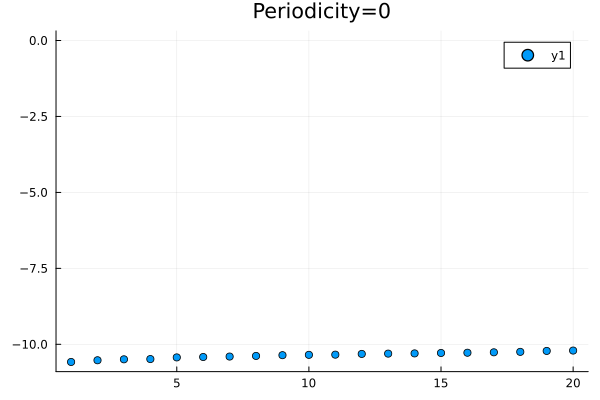

In [49]:
using Plots
plot(1:20,Hubbard_States[1],seriestype=:scatter,title="Periodicity=$(periodicity)")

In [35]:
z = reshape(real(expect_list), Nx, Ny)
heatmap(z, c=:thermal, xlabel="x", ylabel="y", title=("Nx=$Nx,Ny=$Ny,co=$cut_off,PN=$pn,U=$U \n Psi($index_eig_states), Periodicity=$periodicity"))

LoadError: DimensionMismatch: new dimensions (8, 10) must be consistent with array size 0

# Animation

In [36]:
# animated_exp_list = zeros(N,1,length(r_hubbard_states))
# function animated_e_l()
#     for i in 1:length(r_hubbard_states)
#         expect_list=[]
#         for j in 1:N
#             T = NM_MB_Array_Storage[:,:,j]
#             Op = Operator(BL,BR,T)
#             push!(expect_list,expect(Op, r_hubbard_states[i]))
#         end
#         animated_exp_list[:,:,i] = real(expect_list)
#     end
#     return animated_exp_list
# end

In [37]:
# k = 1
# initial_condition = reshape(animated_e_l()[:,:,k], Nx, Ny) #psi_1 (psi_k)'e karşılık gelen density matrix
# heatmap(initial_condition)

In [38]:
# initial_condition = reshape(animated_e_l()[:,:,1], Nx, Ny)
# fps = 20
# function heatgif(initial_condition)
#     p = heatmap(initial_condition, xlabel="x", ylabel="y", title=("Nx=$Nx,Ny=$Ny,co=$cut_off,PN=$pn,U=$U, fps=$fps"))
#     anim = @animate for i=1:length(r_hubbard_states)
#         h_map_matrix = reshape(animated_e_l()[:,:,i],Nx,Ny)
#         heatmap!(p[1], h_map_matrix)
#     end
#     return anim
# end

In [39]:
# anim = heatgif(initial_condition)
# gif(anim, "OUTPUT.gif", fps=fps)